# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [6]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [7]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [8]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

In [9]:
# Parameter Sweep for Hyperparameters
n_feature_kept = 2000
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [10]:
%%time
path = os.path.join('..', 'download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 1min 46s, sys: 2.79 s, total: 1min 49s
Wall time: 1min 57s


In [11]:
%%time
path = os.path.join('..', 'download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 57.3 s, sys: 2.41 s, total: 59.7 s
Wall time: 59.7 s


In [12]:
y = Y[GENE]

In [13]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [14]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Set aside 10% of the data for testing

In [15]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,530 features, 6,575 training samples, 731 testing samples'

## PCA for feature selection

In [16]:
# select the top features with the PCA
feature_transform = PCA(n_components=n_feature_kept)

## Define pipeline and Cross validation model fitting

In [17]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
clf = SGDClassifier(random_state=0, class_weight='balanced',
                    loss=param_fixed['loss'], penalty=param_fixed['penalty'])

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    feature_transform,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [18]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_


CPU times: user 17min 32s, sys: 18.3 s, total: 17min 50s
Wall time: 4min 58s


In [19]:
clf_grid.best_params_

{'alpha': 0.1, 'l1_ratio': 0.05}

In [20]:
best_clf

SGDClassifier(alpha=0.1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.05,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=0, shuffle=True,
       verbose=0, warm_start=False)

## Visualize hyperparameters performance

In [21]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## Process Mutation Matrix

In [22]:
cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
cv_score_df.head(2)

,alpha,fold,l1_ratio,score
0,0.000001,0,0.0,0.843410
1,0.000001,1,0.0,0.840747


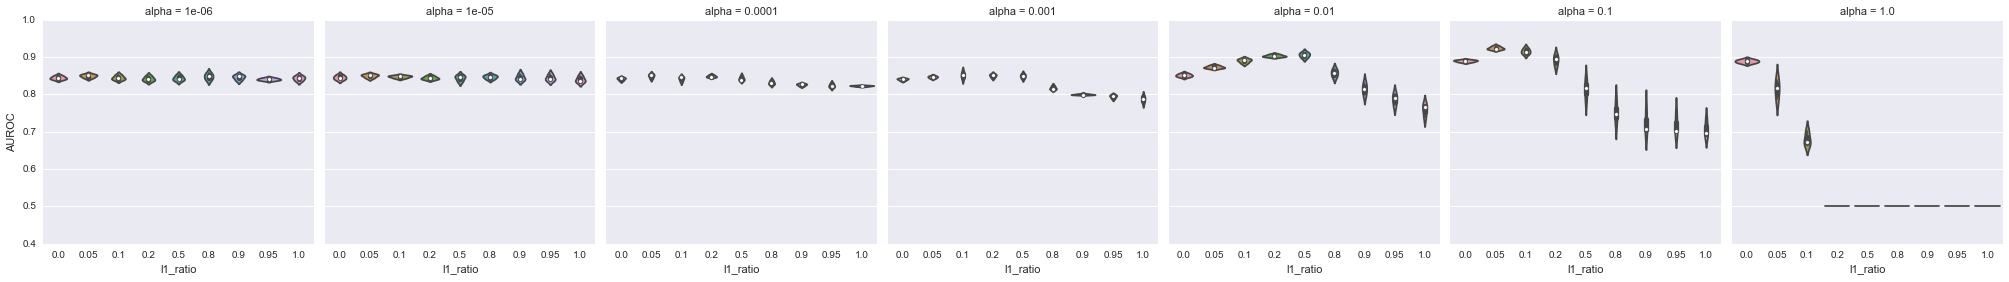

In [23]:
# Cross-validated performance distribution
facet_grid = sns.factorplot(x='l1_ratio', y='score', col='alpha',
    data=cv_score_df, kind='violin', size=4, aspect=1)
facet_grid.set_ylabels('AUROC');

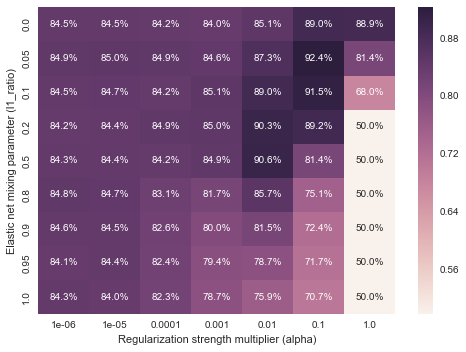

In [24]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_score_df, values='score', index='l1_ratio', columns='alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [25]:
y_pred_train = pipeline.decision_function(X_train)
y_pred_test = pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

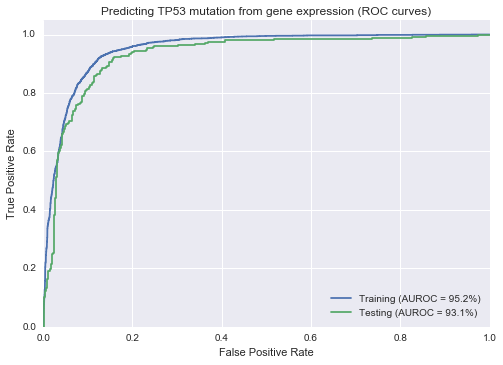

In [26]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## What are the classifier coefficients?

In [27]:
#coef_df = pd.DataFrame(best_clf.coef_.transpose(), index=X.columns[feature_mask], columns=['weight'])
coef_df = pd.DataFrame(best_clf.coef_.transpose(), columns=['weight'])
coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [28]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'84.8% zero coefficients; 165 negative and 140 positive coefficients'

In [29]:
coef_df.head(10)

,weight,abs
3,0.444802,0.444802
0,0.344527,0.344527
1,0.321563,0.321563
2,-0.311362,0.311362
33,-0.263867,0.263867
52,-0.205953,0.205953
47,-0.196424,0.196424
10,-0.192390,0.192390
13,0.189448,0.189448
28,0.178836,0.178836


The results are not surprising. TP53 is a transcription modulator and when it mutated in a tumor, the cell goes haywire. This makes finding a transcriptional signature fairly easy. Also, the genes that the classifier uses is interesting, but not necessarily novel.

1. TP53 is a [transcription factor](https://en.wikipedia.org/wiki/Transcription_factor "TF wiki") that regulates many genes including EDA2R. Studies have linked EDA2R (or XEDAR) to [increased survival in colon cancer patients](http://www.ncbi.nlm.nih.gov/pubmed/19543321) and [losing hair as a result of chemotherapy](http://onlinelibrary.wiley.com/doi/10.1016/j.febslet.2010.04.058/full)
2. SPATA18 is a gene associated with spermatogenesis and is a transcription factor for TP53. It's association with TP53 was [recently discovered](http://www.ncbi.nlm.nih.gov/pubmed/21300779) in 2011.
3. C6orf138 (or [PTCHD4](http://www.genecards.org/cgi-bin/carddisp.pl?gene=PTCHD4)) is also a transcriptional target for TP53 and was only recently discovered in [2014 to repress hedgehog signalling](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4239647/).
4. The list goes on and includes several other TP53 targets...

## Investigate the predictions

In [30]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', pipeline.decision_function(X)),
    ('probability', pipeline.predict_proba(X)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [31]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-EI-6513-01,TCGA-EI-6513-01,1,0,2.935155,0.949557,95.0%
TCGA-L5-A8NR-01,TCGA-L5-A8NR-01,0,0,2.127461,0.893544,89.4%
TCGA-21-1081-01,TCGA-21-1081-01,0,0,1.952287,0.875696,87.6%
TCGA-13-1506-01,TCGA-13-1506-01,0,0,1.873090,0.866815,86.7%
TCGA-CV-7261-01,TCGA-CV-7261-01,0,0,1.852441,0.864413,86.4%
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,1.816788,0.860180,86.0%
TCGA-24-2298-01,TCGA-24-2298-01,0,0,1.797701,0.857869,85.8%
TCGA-CK-5912-01,TCGA-CK-5912-01,0,0,1.778048,0.855456,85.5%
TCGA-B6-A0I1-01,TCGA-B6-A0I1-01,0,0,1.777075,0.855335,85.5%


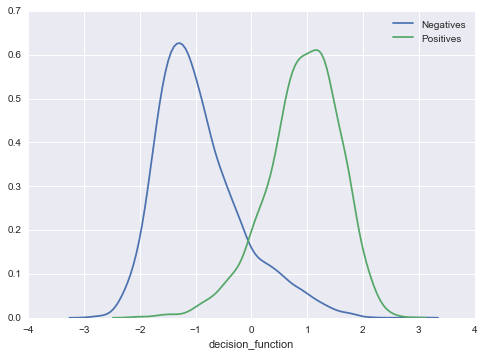

In [32]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

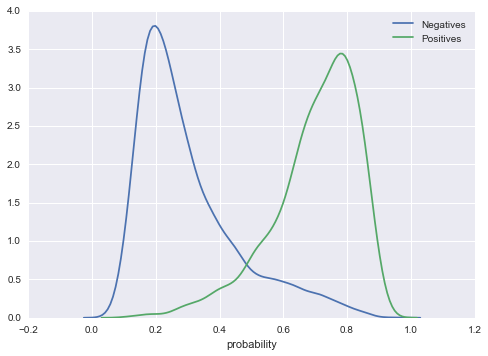

In [33]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')